In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ============================================================
# 0) LOAD DATA
# ============================================================

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

X = R.astype(float)                 # (images × neurons)
top1 = np.argmax(vit, axis=1)
y_real = (top1 <= 397).astype(int)  # animate/inanimate label

print("X:", X.shape, "y mean (real):", y_real.mean())

X: (118, 39209) y mean: 0.5338983050847458
Loading 118 images...
Loaded images array length: 118
Extracting geometry features...
Geometry feature matrix: (118, 44)
Geometry SVM accuracy: 0.5338983050847458
Neural decoder accuracy: 1.0
Margin correlation (neural vs geom): 0.2811635617464713
Error consistency: 0.5338983050847458


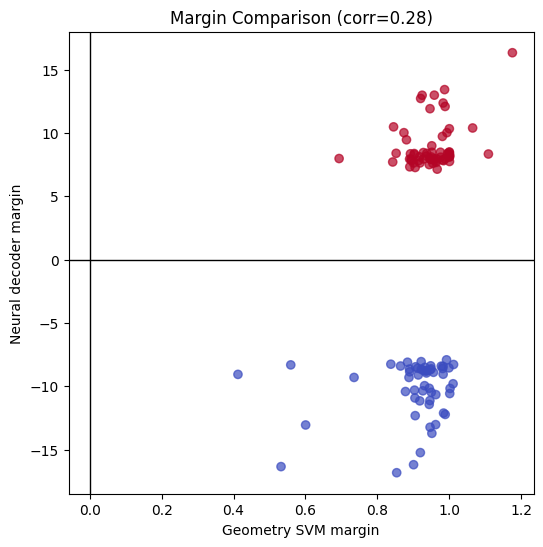


===== SUMMARY =====
Geometry model accuracy: 0.5338983050847458
Neural model accuracy: 1.0
Margin correlation: 0.2811635617464713
Error consistency: 0.5338983050847458


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.fft import fft2, fftshift

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# ============================================================
# 0) LOAD DATA
# ============================================================

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'
IMG_DIR     = '/home/maria/ProjectionSort/data/images/images'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

X = R.astype(float)                 # (images × neurons)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)       # semantic labels

print("X:", X.shape, "y mean:", y.mean())


# ============================================================
# 1) LOAD IMAGES FROM DISK
# ============================================================

# Read files in sorted order so index 0 = scene 0, etc.
img_files = sorted([
    os.path.join(IMG_DIR, fname)
    for fname in os.listdir(IMG_DIR)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

if len(img_files) != len(vit):
    raise ValueError(f"Found {len(img_files)} images but {len(vit)} Vit embeddings")

print(f"Loading {len(img_files)} images...")

images = [imread(f) for f in img_files]

print("Loaded images array length:", len(images))


# ============================================================
# 2) GEOMETRIC FEATURE EXTRACTION
# ============================================================

def extract_geometry_features(img):
    """
    img: (H, W, 3) array
    Returns simple geometric descriptors:
    - edge magnitude histogram
    - radial power spectrum slice
    """
    if img.ndim == 2:  # grayscale fallback
        gray = img
    else:
        gray = rgb2gray(img)

    # Edge map
    edges = sobel(gray)
    edge_hist, _ = np.histogram(edges.flatten(), bins=32, range=(0, edges.max()))

    # Power spectrum
    F = np.abs(fftshift(fft2(gray)))
    ps_radial = F.mean(axis=0)[::8]  # crude slice

    feat = np.concatenate([
        edge_hist / (edge_hist.sum() + 1e-8),
        ps_radial / (ps_radial.sum() + 1e-8),
    ])
    return feat


print("Extracting geometry features...")
geom_feats = np.array([extract_geometry_features(img) for img in images])
print("Geometry feature matrix:", geom_feats.shape)


# ============================================================
# 3) GEOMETRIC CLASSIFIER
# ============================================================

clf_geom = SVC(kernel='rbf', C=1.0, probability=True)
clf_geom.fit(geom_feats, y)

geom_margin = clf_geom.decision_function(geom_feats)
geom_pred = clf_geom.predict(geom_feats)

geom_acc = accuracy_score(y, geom_pred)
print("Geometry SVM accuracy:", geom_acc)


# ============================================================
# 4) NEURAL DECODER
# ============================================================

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

clf_neural = LogisticRegression(C=1.0, max_iter=5000)
clf_neural.fit(X_std, y)

neural_margin = clf_neural.decision_function(X_std)
neural_pred = clf_neural.predict(X_std)

neural_acc = accuracy_score(y, neural_pred)
print("Neural decoder accuracy:", neural_acc)


# ============================================================
# 5) ERROR PATTERN COMPARISON
# ============================================================

corr = np.corrcoef(neural_margin, geom_margin)[0, 1]
print("Margin correlation (neural vs geom):", corr)

neural_err = (neural_pred != y).astype(int)
geom_err   = (geom_pred != y).astype(int)

error_consistency = np.mean(neural_err == geom_err)
print("Error consistency:", error_consistency)


# ============================================================
# 6) VISUALIZE
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(geom_margin, neural_margin, c=y, cmap='coolwarm', alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='k', lw=1)
plt.xlabel("Geometry SVM margin")
plt.ylabel("Neural decoder margin")
plt.title(f"Margin Comparison (corr={corr:.2f})")
plt.show()


# ============================================================
# 7) SUMMARY
# ============================================================

print("\n===== SUMMARY =====")
print("Geometry model accuracy:", geom_acc)
print("Neural model accuracy:", neural_acc)
print("Margin correlation:", corr)
print("Error consistency:", error_consistency)


X: (118, 39209) y mean: 0.5338983050847458
Loading 118 images...
Loaded images array length: 118
Extracting geometry features...
Geometry feature matrix: (118, 44)
Geometry SVM accuracy: 0.5338983050847458
Neural PCA shape: (118, 10)
Neural decoder accuracy (10 PCs): 0.7457627118644068
Margin correlation (neural vs geom): 0.336685783917637
Error consistency: 0.5169491525423728


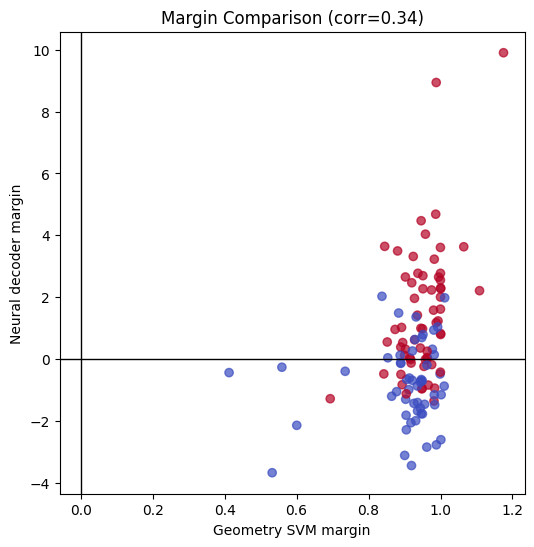


===== SUMMARY =====
Geometry model accuracy: 0.5338983050847458
Neural model accuracy: 0.7457627118644068
Margin correlation: 0.336685783917637
Error consistency: 0.5169491525423728


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.fft import fft2, fftshift

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# ============================================================
# 0) LOAD DATA
# ============================================================

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'
IMG_DIR     = '/home/maria/ProjectionSort/data/images/images'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

X = R.astype(float)                 # (images × neurons)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)       # semantic labels

print("X:", X.shape, "y mean:", y.mean())


# ============================================================
# 1) LOAD IMAGES FROM DISK
# ============================================================

# Read files in sorted order so index 0 = scene 0, etc.
img_files = sorted([
    os.path.join(IMG_DIR, fname)
    for fname in os.listdir(IMG_DIR)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

if len(img_files) != len(vit):
    raise ValueError(f"Found {len(img_files)} images but {len(vit)} Vit embeddings")

print(f"Loading {len(img_files)} images...")

images = [imread(f) for f in img_files]

print("Loaded images array length:", len(images))


# ============================================================
# 2) GEOMETRIC FEATURE EXTRACTION
# ============================================================

def extract_geometry_features(img):
    """
    img: (H, W, 3) array
    Returns simple geometric descriptors:
    - edge magnitude histogram
    - radial power spectrum slice
    """
    if img.ndim == 2:  # grayscale fallback
        gray = img
    else:
        gray = rgb2gray(img)

    # Edge map
    edges = sobel(gray)
    edge_hist, _ = np.histogram(edges.flatten(), bins=32, range=(0, edges.max()))

    # Power spectrum
    F = np.abs(fftshift(fft2(gray)))
    ps_radial = F.mean(axis=0)[::8]  # crude slice

    feat = np.concatenate([
        edge_hist / (edge_hist.sum() + 1e-8),
        ps_radial / (ps_radial.sum() + 1e-8),
    ])
    return feat


print("Extracting geometry features...")
geom_feats = np.array([extract_geometry_features(img) for img in images])
print("Geometry feature matrix:", geom_feats.shape)


# ============================================================
# 3) GEOMETRIC CLASSIFIER
# ============================================================

clf_geom = SVC(kernel='rbf', C=1.0, probability=True)
clf_geom.fit(geom_feats, y)

geom_margin = clf_geom.decision_function(geom_feats)
geom_pred = clf_geom.predict(geom_feats)

geom_acc = accuracy_score(y, geom_pred)
print("Geometry SVM accuracy:", geom_acc)


# ============================================================
# 4) NEURAL DECODER (PCA -> Logistic Regression)
# ============================================================

# Standardize neural responses
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# PCA to 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_std)

print("Neural PCA shape:", X_pca.shape)

# Fit logistic regression on 10 PCs
clf_neural = LogisticRegression(C=1.0, max_iter=5000)
clf_neural.fit(X_pca, y)

neural_margin = clf_neural.decision_function(X_pca)
neural_pred = clf_neural.predict(X_pca)

neural_acc = accuracy_score(y, neural_pred)
print("Neural decoder accuracy (10 PCs):", neural_acc)



# ============================================================
# 5) ERROR PATTERN COMPARISON
# ============================================================

corr = np.corrcoef(neural_margin, geom_margin)[0, 1]
print("Margin correlation (neural vs geom):", corr)

neural_err = (neural_pred != y).astype(int)
geom_err   = (geom_pred != y).astype(int)

error_consistency = np.mean(neural_err == geom_err)
print("Error consistency:", error_consistency)


# ============================================================
# 6) VISUALIZE
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(geom_margin, neural_margin, c=y, cmap='coolwarm', alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='k', lw=1)
plt.xlabel("Geometry SVM margin")
plt.ylabel("Neural decoder margin")
plt.title(f"Margin Comparison (corr={corr:.2f})")
plt.show()


# ============================================================
# 7) SUMMARY
# ============================================================

print("\n===== SUMMARY =====")
print("Geometry model accuracy:", geom_acc)
print("Neural model accuracy:", neural_acc)
print("Margin correlation:", corr)
print("Error consistency:", error_consistency)


In [5]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

neural_margins_cv = np.zeros(len(y))
geom_margins_cv   = np.zeros(len(y))
neural_preds_cv   = np.zeros(len(y), dtype=int)
geom_preds_cv     = np.zeros(len(y), dtype=int)

for train_idx, test_idx in kfold.split(X, y):
    # ----- Neural pipeline -----
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X[train_idx])
    X_test_std  = scaler.transform(X[test_idx])

    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca  = pca.transform(X_test_std)

    clf_neural = LogisticRegression(C=1.0, max_iter=5000)
    clf_neural.fit(X_train_pca, y[train_idx])

    neural_margins_cv[test_idx] = clf_neural.decision_function(X_test_pca)
    neural_preds_cv[test_idx]   = clf_neural.predict(X_test_pca)

    # ----- Geometry pipeline -----
    clf_geom = SVC(kernel='rbf', C=1.0, probability=True)
    clf_geom.fit(geom_feats[train_idx], y[train_idx])

    geom_margins_cv[test_idx] = clf_geom.decision_function(geom_feats[test_idx])
    geom_preds_cv[test_idx]   = clf_geom.predict(geom_feats[test_idx])

# Now compute CV metrics
from sklearn.metrics import accuracy_score

neural_acc_cv = accuracy_score(y, neural_preds_cv)
geom_acc_cv   = accuracy_score(y, geom_preds_cv)
corr_cv       = np.corrcoef(neural_margins_cv, geom_margins_cv)[0, 1]
err_neural_cv = (neural_preds_cv != y).astype(int)
err_geom_cv   = (geom_preds_cv != y).astype(int)
err_cons_cv   = np.mean(err_neural_cv == err_geom_cv)

print("Neural CV accuracy:", neural_acc_cv)
print("Geometry CV accuracy:", geom_acc_cv)
print("CV margin corr:", corr_cv)
print("CV error consistency:", err_cons_cv)


Neural CV accuracy: 0.6779661016949152
Geometry CV accuracy: 0.5338983050847458
CV margin corr: 0.10108453434304737
CV error consistency: 0.5508474576271186


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.fft import fft2, fftshift

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr

import torch
import torchvision.models as models
import torchvision.transforms as T


# ============================================================
# 0) LOAD ORIGINAL DATA
# ============================================================

VIT_PATH    = "/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl"
NEURAL_PATH = "/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy"
IMG_DIR     = "/home/maria/ProjectionSort/data/images/images"

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R   = np.load(NEURAL_PATH).T               # (118 × 39209)
X   = R.astype(float)

top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)              # animate/inanimate labels


# ============================================================
# 1) LOAD IMAGES
# ============================================================

img_files = sorted([
    os.path.join(IMG_DIR, f)
    for f in os.listdir(IMG_DIR)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

assert len(img_files) == len(X)

print("Loaded", len(img_files), "images.")
images = [imread(f) for f in img_files]


# ============================================================
# 2) SHAPE FEATURES (Edges + Power Spectrum)
# ============================================================

def extract_shape_feats(img):
    if img.ndim == 2:
        gray = img
    else:
        gray = rgb2gray(img)

    # Edges
    edges = sobel(gray)
    edge_hist, _ = np.histogram(edges.flatten(), bins=32, range=(0, edges.max()))

    # FFT power spectrum
    F = np.abs(fftshift(fft2(gray)))
    ps = F.mean(axis=0)[::8]

    return np.concatenate([
        edge_hist / (edge_hist.sum() + 1e-8),
        ps / (ps.sum() + 1e-8)
    ])

shape_feats = np.array([extract_shape_feats(img) for img in images])
print("Shape features:", shape_feats.shape)


# ============================================================
# 3) TEXTURE FEATURES (ConvNet)
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(device)
vgg.eval()

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

def extract_texture_feats(img):
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = vgg(img_t)
    feat = feat.mean(dim=[2, 3]).cpu().numpy().ravel()
    return feat

print("Extracting texture features via VGG16...")
texture_feats = np.array([extract_texture_feats(img) for img in images])
print("Texture features:", texture_feats.shape)


# ============================================================
# 4) PCA ON SHAPE / TEXTURE
# ============================================================

def normalize(v): 
    return (v - v.min()) / (v.max() - v.min())

# ---- Shape PCA ----
sc_shape = StandardScaler()
shape_std = sc_shape.fit_transform(shape_feats)
pca_shape = PCA(n_components=5)
shape_pcs = pca_shape.fit_transform(shape_std)
shape_axis = normalize(shape_pcs[:, 0])     # continuous 1D shape coordinate

# ---- Texture PCA ----
sc_tex = StandardScaler()
tex_std = sc_tex.fit_transform(texture_feats)
pca_tex = PCA(n_components=5)
tex_pcs = pca_tex.fit_transform(tex_std)
texture_axis = normalize(tex_pcs[:, 0])     # continuous 1D texture coordinate


# ============================================================
# 5) NEURAL PCA (10 PCs)
# ============================================================

sc_neural = StandardScaler()
X_std = sc_neural.fit_transform(X)

pca_neural = PCA(n_components=10)
X_pca = pca_neural.fit_transform(X_std)

neural_axis = normalize(X_pca[:, 0])        # continuous neural coordinate


# ============================================================
# 6) CROSS-SPACE REGRESSION
# ============================================================

A = np.vstack([texture_axis, shape_axis]).T   # (118 × 2)

reg = LinearRegression()
reg.fit(A, neural_axis)

pred_neural = reg.predict(A)
r2 = reg.score(A, neural_axis)

print("\n=== CROSS-SPACE REGRESSION RESULTS ===")
print("R²(neural_axis explained by [texture_axis, shape_axis]):", r2)


# ============================================================
# 7) RESIDUAL SEMANTIC CORRELATION
# ============================================================

residual = neural_axis - pred_neural

rho_resid_sem, _ = spearmanr(residual, y)

print("Spearman(residual, semantic label):", rho_resid_sem)


# ============================================================
# 8) AXIS PAIRWISE CORRELATIONS
# ============================================================

rho_tex_neu, _  = spearmanr(texture_axis, neural_axis)
rho_shp_neu, _  = spearmanr(shape_axis, neural_axis)
rho_tex_shp, _  = spearmanr(texture_axis, shape_axis)

print("\n=== AXIS CORRELATIONS ===")
print("Spearman(texture, neural)=", rho_tex_neu)
print("Spearman(shape, neural)  =", rho_shp_neu)
print("Spearman(texture, shape) =", rho_tex_shp)


# ============================================================
# 9) PLOTS (OPTIONAL)
# ============================================================

plt.figure(figsize=(6,6))
plt.scatter(texture_axis, neural_axis, c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("Texture PC1 axis")
plt.ylabel("Neural PC1 axis")
plt.title(f"Texture vs Neural (rho={rho_tex_neu:.2f})")
plt.axhline(0, color='black'); plt.axvline(0, color='black')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(shape_axis, neural_axis, c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("Shape PC1 axis")
plt.ylabel("Neural PC1 axis")
plt.title(f"Shape vs Neural (rho={rho_shp_neu:.2f})")
plt.axhline(0, color='black'); plt.axvline(0, color='black')
plt.show()


Loaded 118 images.
Shape features: (118, 44)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/maria/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:24<00:00, 22.7MB/s] 


Extracting texture features via VGG16...


RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]